# What is UNet


The **U-Net** architecture stems from the so-called “fully convolutional network” first proposed by Long, Shelhamer, and Darrell.

The main idea is to supplement a usual contracting network by successive layers, where pooling operations are replaced by upsampling operators. Hence these layers increase the resolution of the output. What's more, a successive convolutional layer can then learn to assemble a precise output based on this information.

One important modification in U-Net is that there are a large number of feature channels in the upsampling part, which allow the network to propagate context information to higher resolution layers. As a consequence, the expansive path is more or less symmetric to the contracting part, and yields a u-shaped architecture. The network only uses the valid part of each convolution without any fully connected layers. To predict the pixels in the border region of the image, the missing context is extrapolated by mirroring the input image. This tiling strategy is important to apply the network to large images, since otherwise the resolution would be limited by the GPU memory. 

There are many applications of U-Net in biomedical image segmentation, such as brain image segmentation (''BRATS'') and liver image segmentation ("siliver07"). Variations of the U-Net have also been applied for medical image reconstruction.Here are some variants and applications of U-Net as follows:

*   Pixel-wise regression using U-Net and its application on pansharpening

*   3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation
* TernausNet: U-Net with VGG11 Encoder Pre-Trained on ImageNet for Image Segmentation.

[Read more Here.](https://en.wikipedia.org/wiki/U-Net)

Dataset: [Kaggle - 2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018/data)



# Importing Libraries

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Input, Conv2DTranspose
from keras.layers import concatenate

import os
import numpy as np

import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 128
IMG_CHANNELS = 3

# Load Data

In [ ]:
# !unzip /content/drive/MyDrive/stage1_test.zip -d test
# !unzip /content/drive/MyDrive/stage1_train.zip -d train

In [4]:
TRAIN_DIR = '/content/train/'
TEST_DIR = '/content/test/'

In [5]:
# Returns the list of folders in train path
train_ids = next(os.walk(TRAIN_DIR))[1] 
test_ids = next(os.walk(TEST_DIR))[1]

In [11]:
X_train = np.zeros((len(train_ids), IMG_SIZE, IMG_SIZE, IMG_CHANNELS),
                   dtype=np.uint8)
y_train = np.zeros((len(train_ids), IMG_SIZE, IMG_SIZE, 1),
                   dtype=np.bool)

In [12]:
print('Resizing training images and masks')
for n, id_ in tqdm.tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_DIR + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_SIZE, IMG_SIZE), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_SIZE, IMG_SIZE), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    y_train[n] = mask   


  0%|          | 1/670 [00:00<01:44,  6.38it/s]

Resizing training images and masks



100%|██████████| 670/670 [05:58<00:00,  1.87it/s]


In [14]:
# test images
X_test = np.zeros((len(test_ids), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm.tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_DIR + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_SIZE, IMG_SIZE), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')


  6%|▌         | 4/65 [00:00<00:01, 35.08it/s]

Resizing test images



100%|██████████| 65/65 [00:01<00:00, 36.12it/s]

Done!


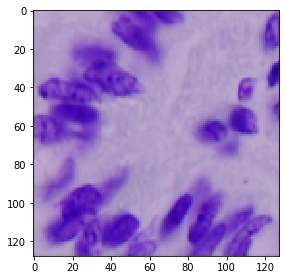

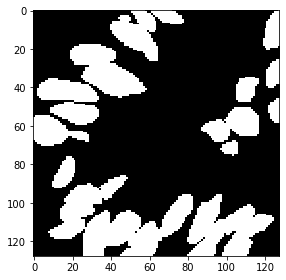

In [17]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

In [19]:
X_train.shape, X_test.shape

((670, 128, 128, 3), (65, 128, 128, 3))

# Building the UNet Model

In [20]:
# Input layer
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS))

# Convert pixels to floating point
s = tf.keras.layers.Lambda(lambda x:x/255.)(inputs)

# Contraction path

#Block 1
conv1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu',
               kernel_initializer = 'he_normal', padding='same')(s)
drop1 = Dropout(0.1)(conv1)
conv2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu',
                 kernel_initializer= 'he_normal', padding='same')(drop1)
pool1 = MaxPooling2D(pool_size=(2,2))(conv2)

#Block 2
conv3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu',
               kernel_initializer = 'he_normal', padding='same')(pool1)
drop2 = Dropout(0.1)(conv3)
conv4 = Conv2D(filters=32, kernel_size=(3,3), activation='relu',
               kernel_initializer = 'he_normal', padding='same')(drop2)
pool2 = MaxPooling2D(pool_size=(2,2))(conv4)

#Block 3
conv5 = Conv2D(filters=64, kernel_size=(3,3), activation='relu',
               kernel_initializer = 'he_normal', padding='same')(pool2)
drop3 = Dropout(0.1)(conv5)
conv6 = Conv2D(filters=64, kernel_size=(3,3), activation='relu',
               kernel_initializer = 'he_normal', padding='same')(drop3)
pool3 = MaxPooling2D(pool_size=(2,2))(conv6)

#Block 4
conv7 = Conv2D(filters=128, kernel_size=(3,3), activation='relu',
               kernel_initializer = 'he_normal', padding='same')(pool3)
drop4 = Dropout(0.1)(conv7)
conv8 = Conv2D(filters=128, kernel_size=(3,3), activation='relu',
               kernel_initializer = 'he_normal', padding='same')(drop4)
pool4 = MaxPooling2D(pool_size=(2,2))(conv8)

#Block 5
conv9 = Conv2D(filters=256, kernel_size=(3,3), activation='relu',
               kernel_initializer = 'he_normal', padding='same')(pool4)
drop5 = Dropout(0.1)(conv9)
conv10 = Conv2D(filters=256, kernel_size=(3,3), activation='relu',
               kernel_initializer = 'he_normal', padding='same')(drop5)

# Expansion Path 

# Upsampling block 1
upsample1 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv10)
concat1 = concatenate([upsample1, conv8])
upconv1 = Conv2D(128, (3,3), activation='relu', padding='same',
                 kernel_initializer='he_normal')(concat1)
updrop1 = Dropout(0.1)(upconv1)
upconv1 = Conv2D(128, (3,3), activation='relu', padding='same',
                 kernel_initializer='he_normal')(updrop1)

# Upsampling block 2
upsample2 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(upconv1)
concat2 = concatenate([upsample2, conv6])
upconv2 = Conv2D(64, (3,3), activation='relu', padding='same',
                 kernel_initializer='he_normal')(concat2)
updrop2 = Dropout(0.1)(upconv2)
upconv2 = Conv2D(64, (3,3), activation='relu', padding='same',
                 kernel_initializer='he_normal')(updrop2)

# Upsampling block 3
upsample3 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(upconv2)
concat3 = concatenate([upsample3, conv4])
upconv3 = Conv2D(32, (3,3), activation='relu', padding='same',
                 kernel_initializer='he_normal')(concat3)
updrop3 = Dropout(0.1)(upconv3)
upconv3 = Conv2D(32, (3,3), activation='relu', padding='same',
                 kernel_initializer='he_normal')(updrop3)

# Upsampling block 4
upsample4 = Conv2DTranspose(16, (2,2),  strides=(2,2), padding='same')(upconv3)
concat4 = concatenate([upsample4, conv2])
upconv4 = Conv2D(16, (3,3), activation='relu', padding='same',
                 kernel_initializer='he_normal')(concat4)
updrop4 = Dropout(0.1)(upconv4)
upconv4 = Conv2D(16, (3,3), activation='relu', padding='same',
                 kernel_initializer='he_normal')(updrop4)

# Final Layer
outputs = Conv2D(1, (1,1), activation='sigmoid')(upconv4)

# Create model object
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [21]:
# Defining Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('saved_model.h5', verbose=1,
                                                 save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tensorbrd = tf.keras.callbacks.TensorBoard(log_dir='./logs')
    
callbacks = [checkpoint, earlystop, tensorbrd]


In [23]:
history = model.fit(X_train,
                    y_train,
                    validation_split=0.1,
                    batch_size=16,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
38/38 [==============================] - 2s 45ms/step - loss: 0.0872 - accuracy: 0.9659 - val_loss: 0.0888 - val_accuracy: 0.9688

Epoch 00001: val_loss improved from 0.09159 to 0.08878, saving model to saved_model.h5
Epoch 2/50
38/38 [==============================] - 1s 39ms/step - loss: 0.0840 - accuracy: 0.9672 - val_loss: 0.0876 - val_accuracy: 0.9695

Epoch 00002: val_loss improved from 0.08878 to 0.08764, saving model to saved_model.h5
Epoch 3/50
38/38 [==============================] - 1s 39ms/step - loss: 0.0813 - accuracy: 0.9685 - val_loss: 0.0858 - val_accuracy: 0.9704

Epoch 00003: val_loss improved from 0.08764 to 0.08584, saving model to saved_model.h5
Epoch 4/50
38/38 [==============================] - 1s 39ms/step - loss: 0.0807 - accuracy: 0.9685 - val_loss: 0.0856 - val_accuracy: 0.9705

Epoch 00004: val_loss improved from 0.08584 to 0.08557, saving model to saved_model.h5
Epoch 5/50
38/38 [==============================] - 1s 39ms/step - loss: 0.0788 - ac

3/3 [==============================] - 0s 85ms/step


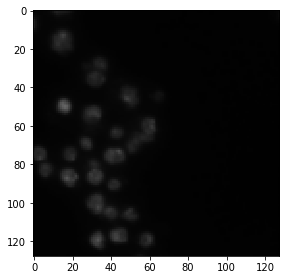

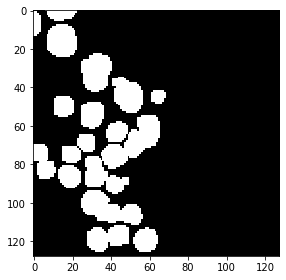

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


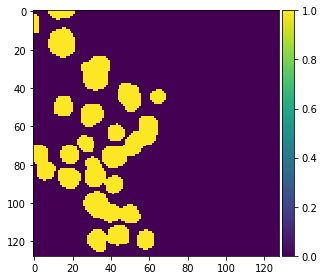

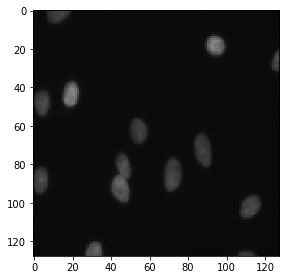

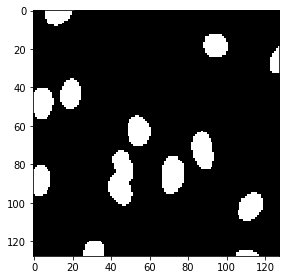

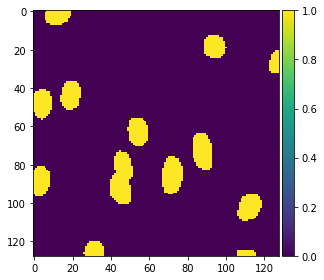

In [24]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()